## PPO - proximal policy optimization

https://huggingface.co/learn/deep-rl-course/unit8/hands-on-cleanrl \
https://iclr-blog-track.github.io/2022/03/25/ppo-implementation-details \
https://pytorch.org/tutorials/intermediate/reinforcement_ppo.html \
https://huggingface.co/learn/deep-rl-course/unit8/additional-readings

### Straight way

In [ ]:
import gymnasium

# from huggingface_sb3 import load_from_hub, package_to_hub
# from huggingface_hub import notebook_login  # To log to our Hugging Face account to be able to upload models to the Hub.

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

In [ ]:
import gymnasium as gym

# First, we create our environment called LunarLander-v2
env = gym.make("LunarLander-v2")

# Then we reset this environment
observation, info = env.reset()

for _ in range(10):
    # Take a random action
    action = env.action_space.sample()
    print("Action taken:", action)

    # Do this action in the environment and get
    # next_state, reward, terminated, truncated and info
    observation, reward, terminated, truncated, info = env.step(action)

    # If the game is terminated (in our case we land, crashed) or truncated (timeout)
    if terminated or truncated:
        # Reset the environment
        print("Environment is reset")
        observation, info = env.reset()

env.close()

In [ ]:
# Create the environment
# env = make_vec_env("LunarLander-v2", n_envs=16)
# Create environment
env = gym.make('LunarLander-v2')

# Instantiate the agent
model = PPO('MlpPolicy', env, verbose=1)
# Train the agent
model.learn(total_timesteps=int(2e5))

env.reset()
print("_____OBSERVATION SPACE_____ \n")
print("Observation Space Shape", env.observation_space.shape)
print("Sample observation", env.observation_space.sample())  # Get a random observation

In [ ]:
# We added some parameters to accelerate the training
model = PPO(
    policy="MlpPolicy",
    env=env,
    n_steps=1024,
    batch_size=64,
    n_epochs=4,
    gamma=0.999,
    gae_lambda=0.98,
    ent_coef=0.01,
    verbose=1,
)

In [ ]:
# Train it for 1,000,000 timesteps
model.learn(total_timesteps=10000)
# Save the model
model_name = "ppo-LunarLander-v2"
model.save(model_name)

In [ ]:
# @title
eval_env = Monitor(gym.make("LunarLander-v2"))
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

## Hugging face course - PPO from scratch

In [ ]:
# docs and experiment results can be found at https://docs.cleanrl.dev/rl-algorithms/ppo/#ppopy

import argparse
import os
import random
import time
from distutils.util import strtobool

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical
from torch.utils.tensorboard import SummaryWriter

# from huggingface_hub import HfApi, upload_folder
# from huggingface_hub.repocard import metadata_eval_result, metadata_save

from pathlib import Path
import datetime
import tempfile
import json
import shutil
import imageio

from wasabi import Printer

msg = Printer()


def simple_parser():
    # fmt: off
    parser = argparse.ArgumentParser(description="help/guide/FAQ - <link>",
                                    prog="Load parameters data",
                                    exit_on_error=True)
    # parser.add_argument("--exp-name", type=str, default=os.path.basename(__file__).rstrip(".py"),
    #     help="the name of this experiment")
    parser.add_argument("--num_envs", type=int, default=1,
        help="envs in the experiment")
    parser.add_argument("--num_steps", type=int, default=100,
        help="steps in the experiment")
    parser.add_argument("--seed", type=int, default=1,
        help="seed of the experiment")
    parser.add_argument("--torch-deterministic", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="if toggled, `torch.backends.cudnn.deterministic=False`")
    parser.add_argument("--cuda", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="if toggled, cuda will be enabled by default")
    parser.add_argument("--track", type=lambda x: bool(strtobool(x)), default=False, nargs="?", const=True,
        help="if toggled, this experiment will be tracked with Weights and Biases")
    parser.add_argument("--wandb-project-name", type=str, default="cleanRL",
        help="the wandb's project name")
    parser.add_argument("--wandb-entity", type=str, default=None,
        help="the entity (team) of wandb's project")
    parser.add_argument("--capture-video", type=lambda x: bool(strtobool(x)), default=False, nargs="?", const=True,
        help="weather to capture videos of the agent performances (check out `videos` folder)")

    # Algorithm specific arguments
    parser.add_argument("--env-id", type=str, default="CartPole-v1",
        help="the id of the environment")
    parser.add_argument("--total-timesteps", type=int, default=50000,
        help="total timesteps of the experiments")
    parser.add_argument("--learning-rate", type=float, default=2.5e-4,
        help="the learning rate of the optimizer")
    parser.add_argument("--num-envs", type=int, default=4,
        help="the number of parallel game environments")
    parser.add_argument("--num-steps", type=int, default=128,
        help="the number of steps to run in each environment per policy rollout")
    parser.add_argument("--anneal-lr", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="Toggle learning rate annealing for policy and value networks")
    parser.add_argument("--gae", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="Use GAE for advantage computation")
    parser.add_argument("--gamma", type=float, default=0.99,
        help="the discount factor gamma")
    parser.add_argument("--gae-lambda", type=float, default=0.95,
        help="the lambda for the general advantage estimation")
    parser.add_argument("--num-minibatches", type=int, default=4,
        help="the number of mini-batches")
    parser.add_argument("--update-epochs", type=int, default=4,
        help="the K epochs to update the policy")
    parser.add_argument("--norm-adv", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="Toggles advantages normalization")
    parser.add_argument("--clip-coef", type=float, default=0.2,
        help="the surrogate clipping coefficient")
    parser.add_argument("--clip-vloss", type=lambda x: bool(strtobool(x)), default=True, nargs="?", const=True,
        help="Toggles whether or not to use a clipped loss for the value function, as per the paper.")
    parser.add_argument("--ent-coef", type=float, default=0.01,
        help="coefficient of the entropy")
    parser.add_argument("--vf-coef", type=float, default=0.5,
        help="coefficient of the value function")
    parser.add_argument("--max-grad-norm", type=float, default=0.5,
        help="the maximum norm for the gradient clipping")
    parser.add_argument("--target-kl", type=float, default=None,
        help="the target KL divergence threshold")

    # Adding HuggingFace argument
    parser.add_argument("--repo-id", type=str, default="ThomasSimonini/ppo-CartPole-v1", help="id of the model repository from the Hugging Face Hub {username/repo_name}")

    # args = parser.parse_args()
    # args.batch_size = int(args.num_envs * args.num_steps)
    # args.minibatch_size = int(args.batch_size // args.num_minibatches)
    # fmt: on
    return parser



def make_env(env_id, seed, idx, capture_video, run_name):
    env = gym.make(env_id)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    if capture_video:
        if idx == 0:
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
    # env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return env


def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


class Agent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.critic = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
        self.actor = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, envs.single_action_space.n), std=0.01),
        )

    def get_value(self, x):
        return self.critic(x)

    def get_action_and_value(self, x, action=None):
        logits = self.actor(x)
        probs = Categorical(logits=logits)
        if action is None:
            action = probs.sample()
        return action, probs.log_prob(action), probs.entropy(), self.critic(x)


In [ ]:
parser = simple_parser()
args = parser.parse_args(args=[])
args.batch_size = int(args.num_envs * args.num_steps)
args.minibatch_size = int(args.batch_size // args.num_minibatches)

In [ ]:
# if __name__ == "__main__":
# args = parse_args()
run_name = f"{args.env_id}__{args.seed}__{int(time.time())}"
if args.track:
    import wandb

    wandb.init(
        project=args.wandb_project_name,
        entity=args.wandb_entity,
        sync_tensorboard=True,
        config=vars(args),
        name=run_name,
        monitor_gym=True,
        save_code=True,
    )
writer = SummaryWriter(f"runs/{run_name}")
writer.add_text(
    "hyperparameters",
    "|param|value|\n|-|-|\n%s" % ("\n".join([f"|{key}|{value}|" for key, value in vars(args).items()])),
)

# TRY NOT TO MODIFY: seeding
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

# env setup
envs = gym.vector.SyncVectorEnv(
    [make_env(args.env_id, args.seed + i, i, args.capture_video, run_name) for i in range(args.num_envs)]
)
assert isinstance(envs.single_action_space, gym.spaces.Discrete), "only discrete action space is supported"

agent = Agent(envs).to(device)
optimizer = optim.Adam(agent.parameters(), lr=args.learning_rate, eps=1e-5)

# ALGO Logic: Storage setup
obs = torch.zeros((args.num_steps, args.num_envs) + envs.single_observation_space.shape).to(device)
actions = torch.zeros((args.num_steps, args.num_envs) + envs.single_action_space.shape).to(device)
logprobs = torch.zeros((args.num_steps, args.num_envs)).to(device)
rewards = torch.zeros((args.num_steps, args.num_envs)).to(device)
dones = torch.zeros((args.num_steps, args.num_envs)).to(device)
values = torch.zeros((args.num_steps, args.num_envs)).to(device)

# TRY NOT TO MODIFY: start the game
global_step = 0
start_time = time.time()
next_obs = torch.Tensor(envs.reset()).to(device)
next_done = torch.zeros(args.num_envs).to(device)
num_updates = args.total_timesteps // args.batch_size

for update in range(1, num_updates + 1):
    # Annealing the rate if instructed to do so.
    if args.anneal_lr:
        frac = 1.0 - (update - 1.0) / num_updates
        lrnow = frac * args.learning_rate
        optimizer.param_groups[0]["lr"] = lrnow

    for step in range(0, args.num_steps):
        global_step += 1 * args.num_envs
        obs[step] = next_obs
        dones[step] = next_done

        # ALGO LOGIC: action logic
        with torch.no_grad():
            action, logprob, _, value = agent.get_action_and_value(next_obs)
            values[step] = value.flatten()
        actions[step] = action
        logprobs[step] = logprob

        # TRY NOT TO MODIFY: execute the game and log data.
        next_obs, reward, done, info = envs.step(action.cpu().numpy())
        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs, next_done = torch.Tensor(next_obs).to(device), torch.Tensor(done).to(device)

        for item in info:
            if "episode" in item.keys():
                print(f"global_step={global_step}, episodic_return={item['episode']['r']}")
                writer.add_scalar("charts/episodic_return", item["episode"]["r"], global_step)
                writer.add_scalar("charts/episodic_length", item["episode"]["l"], global_step)
                break

    # bootstrap value if not done
    with torch.no_grad():
        next_value = agent.get_value(next_obs).reshape(1, -1)
        if args.gae:
            advantages = torch.zeros_like(rewards).to(device)
            lastgaelam = 0
            for t in reversed(range(args.num_steps)):
                if t == args.num_steps - 1:
                    nextnonterminal = 1.0 - next_done
                    nextvalues = next_value
                else:
                    nextnonterminal = 1.0 - dones[t + 1]
                    nextvalues = values[t + 1]
                delta = rewards[t] + args.gamma * nextvalues * nextnonterminal - values[t]
                advantages[t] = lastgaelam = delta + args.gamma * args.gae_lambda * nextnonterminal * lastgaelam
            returns = advantages + values
        else:
            returns = torch.zeros_like(rewards).to(device)
            for t in reversed(range(args.num_steps)):
                if t == args.num_steps - 1:
                    nextnonterminal = 1.0 - next_done
                    next_return = next_value
                else:
                    nextnonterminal = 1.0 - dones[t + 1]
                    next_return = returns[t + 1]
                returns[t] = rewards[t] + args.gamma * nextnonterminal * next_return
            advantages = returns - values

    # flatten the batch
    b_obs = obs.reshape((-1,) + envs.single_observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # Optimizing the policy and value network
    b_inds = np.arange(args.batch_size)
    clipfracs = []
    for epoch in range(args.update_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, args.batch_size, args.minibatch_size):
            end = start + args.minibatch_size
            mb_inds = b_inds[start:end]

            _, newlogprob, entropy, newvalue = agent.get_action_and_value(
                b_obs[mb_inds], b_actions.long()[mb_inds]
            )
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > args.clip_coef).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if args.norm_adv:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Policy loss
            pg_loss1 = -mb_advantages * ratio
            pg_loss2 = -mb_advantages * torch.clamp(ratio, 1 - args.clip_coef, 1 + args.clip_coef)
            pg_loss = torch.max(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = newvalue.view(-1)
            if args.clip_vloss:
                v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    newvalue - b_values[mb_inds],
                    -args.clip_coef,
                    args.clip_coef,
                )
                v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()
            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            entropy_loss = entropy.mean()
            loss = pg_loss - args.ent_coef * entropy_loss + v_loss * args.vf_coef

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), args.max_grad_norm)
            optimizer.step()

        if args.target_kl is not None:
            if approx_kl > args.target_kl:
                break

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

    # TRY NOT TO MODIFY: record rewards for plotting purposes
    writer.add_scalar("charts/learning_rate", optimizer.param_groups[0]["lr"], global_step)
    writer.add_scalar("losses/value_loss", v_loss.item(), global_step)
    writer.add_scalar("losses/policy_loss", pg_loss.item(), global_step)
    writer.add_scalar("losses/entropy", entropy_loss.item(), global_step)
    writer.add_scalar("losses/old_approx_kl", old_approx_kl.item(), global_step)
    writer.add_scalar("losses/approx_kl", approx_kl.item(), global_step)
    writer.add_scalar("losses/clipfrac", np.mean(clipfracs), global_step)
    writer.add_scalar("losses/explained_variance", explained_var, global_step)
    print("SPS:", int(global_step / (time.time() - start_time)))
    writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

envs.close()
writer.close()


## PyTorch example

PS here you need pytorch 2.0

First, we will define a set of hyperparameters we will be using for training.

Next, we will focus on creating our environment, or simulator, using TorchRL’s wrappers and transforms.

Next, we will design the policy network and the value model, which is indispensable to the loss function. These modules will be used to configure our loss module.

Next, we will create the replay buffer and data loader.

Finally, we will run our training loop and analyze the results.

In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (Compose, DoubleToFloat, ObservationNorm, StepCounter,
                          TransformedEnv)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, set_exploration_mode
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_cells = 256  # number of cells in each layer i.e. output dim.
lr = 3e-4
max_grad_norm = 1.0

frame_skip = 1
frames_per_batch = 1000 // frame_skip
# For a complete training, bring the number of frames up to 1M
total_frames = 10_000 // frame_skip

sub_batch_size = 64  # cardinality of the sub-samples gathered from the current data in the inner loop
num_epochs = 10  # optimization steps per batch of data collected
clip_epsilon = (
    0.2  # clip value for PPO loss: see the equation in the intro for more context.
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

In [37]:
base_env = GymEnv("InvertedDoublePendulum-v4", device=device, frame_skip=frame_skip)
env = TransformedEnv(
    base_env,
    Compose(
        # normalize observations
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(in_keys=["observation"]),
        StepCounter(),
    ),
)
env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)
print("normalization constant shape:", env.transform[0].loc.shape)
check_env_specs(env)

normalization constant shape: torch.Size([11])
check_env_specs succeeded!


In [38]:
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("input_spec:", env.input_spec)
print("action_spec (as defined by input_spec):", env.action_spec)

observation_spec: CompositeSpec(
    observation: UnboundedContinuousTensorSpec(
         shape=torch.Size([11]), space=None, device=cpu, dtype=torch.float32, domain=continuous),
    step_count: UnboundedDiscreteTensorSpec(
         shape=torch.Size([1]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, contiguous=True), maximum=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, contiguous=True)), device=cpu, dtype=torch.int64, domain=continuous), device=cpu, shape=torch.Size([]))
reward_spec: UnboundedContinuousTensorSpec(
     shape=torch.Size([1]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True), maximum=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True)), device=cpu, dtype=torch.float32, domain=continuous)
input_spec: CompositeSpec(
    action: BoundedTensorSpec(
         shape=torch.Size([1]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([

Policy

In [39]:
actor_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
    NormalParamExtractor(),
)

policy_module = TensorDictModule(
    actor_net, in_keys=["observation"], out_keys=["loc", "scale"]
)

/home/alexander/Documents/Programming/Guidelines/.venv/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [40]:
policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "min": env.action_spec.space.minimum,
        "max": env.action_spec.space.maximum,
    },
    return_log_prob=True,
    # we'll need the log-prob for the numerator of the importance weights
)

Value network

In [41]:
value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)

value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
)

In [42]:
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        loc: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        observation: Tensor(shape=torch.Size([11]), device=cpu, dtype=torch.float32, is_shared=False),
        sample_log_prob: Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, is_shared=False),
        scale: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
        step_count: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, is_shared=False)},
    batch_size=torch.Size([]),
    device=cpu,
    is_shared=False)
Running value: TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        observation: Tensor(shape=torch.Size([11]), device=cpu, dtype=to

Data collector, Replay buffer

In [43]:
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

Loss function

In [44]:
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)

loss_module = ClipPPOLoss(
    actor=policy_module,
    critic=value_module,
    advantage_key="advantage",
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default but we set this for completeness
    value_target_key=advantage_module.value_target_key,
    critic_coef=1.0,
    gamma=0.99,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)

Training

In [45]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames * frame_skip)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optimization step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel() * frame_skip)
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our ``env`` horizon).
        # The ``rollout`` method of the ``env`` can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_mode("mean"), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()

eval cumulative reward:  110.2696 (init:  110.2696), eval step-count: 11, average reward= 9.2346 (init= 9.1540), step count (max): 15, lr policy:  0.0000: 100%|██████████| 1000/1000 [04:35<00:00,  3.62it/s] 


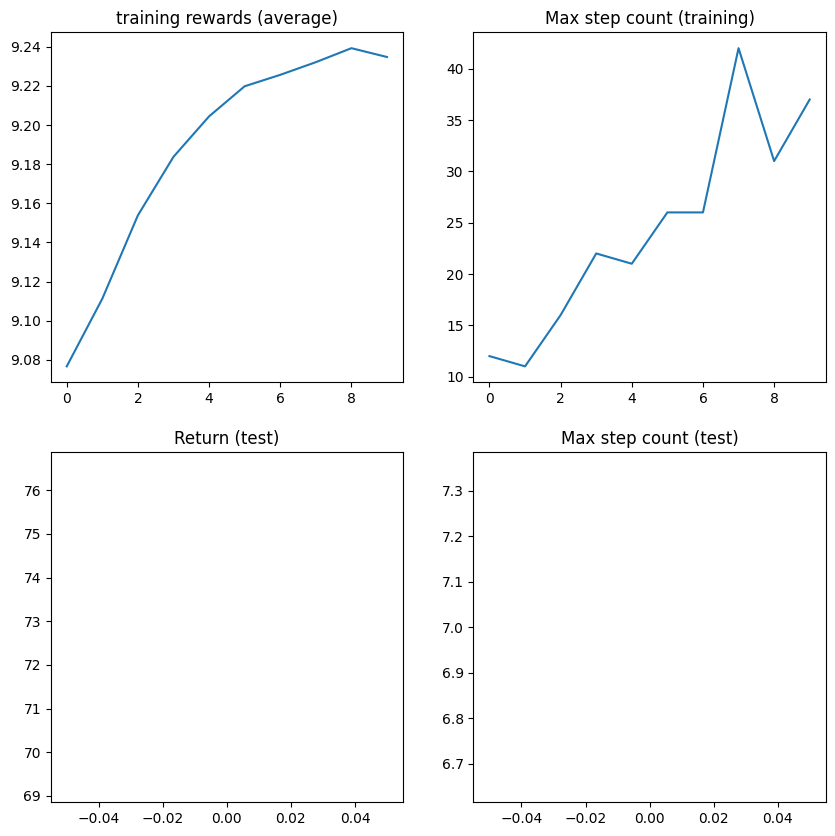

In [46]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()

If you want to experiment with this tutorial a bit more, you can apply the following modifications:

From an efficiency perspective, we could run several simulations in parallel to speed up data collection. Check ParallelEnv for further information.

From a logging perspective, one could add a torchrl.record.VideoRecorder transform to the environment after asking for rendering to get a visual rendering of the inverted pendulum in action. Check torchrl.record to know more.